# Pipeline de estruturação do modelo
## Case Kognita Lab

> Candidato: Oscar J. O. Ayala

> Vaga: Cientista de Dados Júnior

# Conteúdo
1. [**Importação bibliotecas e dados**](#desafio1) <br>
2. [**Conjunto de trinamento e teste**](#desafio2)<br>
3. [**Pré-processamento**](#desafio3)<br> 
4. [**Selecionar e Treinar um Modelo**](#desafio4)<br> 
5. [**Análise e seleção dos melhores modelos**](#desafio5)<br> 
6. [**Modelo final e avaliação o sitema no conjunto de teste**](#desafio6)<br> 

# <a id="desafio1"></a> 1) Importação bibliotecas e dados

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import joblib

In [2]:
data_set = pd.read_csv('dataset/dataset_2021-5-26-10-14.csv', sep = '\t', 
                       encoding = 'utf-8', na_values = 'missing')
data_set.head()

,default_3months,ioi_36months,ioi_3months,valor_por_vencer,valor_vencido,valor_quitado,quant_protestos,valor_protestos,quant_acao_judicial,acao_judicial_valor,...,dividas_vencidas_qtd,falencia_concordata_qtd,tipo_sociedade,opcao_tributaria,atividade_principal,forma_pagamento,valor_total_pedido,month,year,default
0,0,58.000000,18.236092,0.00,0.0,242100.70,0,0.0,0,0.0,...,0,0,empresario (individual),simples nacional,papelaria,30/60/90,34665.674938,6,2019,0
1,1,16.052632,7.500000,224132.85,0.0,4960846.21,0,0.0,0,0.0,...,0,0,sociedade empresaria limitada,NaN,com de equipamentos de informatica,30/60/90,7134.489373,10,2018,0
2,0,13.250000,3.904762,513043.83,0.0,158631.93,1,1800.0,0,0.0,...,0,0,sociedade empresaria limitada,simples nacional,servicos de vigilancia e guarda,NaN,72653.621143,4,2018,0
3,0,136.925000,10.144219,23273.64,0.0,669644.16,0,0.0,0,0.0,...,0,0,empresario (individual),simples nacional,com de equipamentos de informatica,NaN,14576.805783,4,2017,1
4,0,140.333333,17.651678,0.00,0.0,2010.56,0,0.0,0,0.0,...,0,0,sociedade empresaria limitada,simples nacional,com de compon eletron e pecas para eletrod,30/60/90,2655.505663,10,2017,0


In [3]:
# estrutura dos dados
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117273 entries, 0 to 117272
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   default_3months              117273 non-null  int64  
 1   ioi_36months                 117273 non-null  float64
 2   ioi_3months                  117273 non-null  float64
 3   valor_por_vencer             117273 non-null  float64
 4   valor_vencido                117273 non-null  float64
 5   valor_quitado                117273 non-null  float64
 6   quant_protestos              117273 non-null  int64  
 7   valor_protestos              117273 non-null  float64
 8   quant_acao_judicial          117273 non-null  int64  
 9   acao_judicial_valor          117273 non-null  float64
 10  participacao_falencia_valor  117273 non-null  float64
 11  dividas_vencidas_valor       117273 non-null  float64
 12  dividas_vencidas_qtd         117273 non-null  int64  
 13 

# <a id="desafio2"></a> 2) Conjunto de trinamento e teste

> A quantidade de protestos de títulos no Serasa (`quant_protestos`) teoricamente reflete o histórico de inadimplência do cliente. Por isso, o conjunto de teste será representativo desse preditor. A estratificação é utilizada para obter conjuntos de teste e treinamento de forma proporcional.

In [4]:
# Importa-se a função `train_test_split`
from sklearn.model_selection import train_test_split

# Categorização ordinal da variável `median_income`
data_set["quant_protestos_cat"] = np.where(data_set['quant_protestos'].isin([0, 1, 2]), data_set['quant_protestos'], 3)
data_set["quant_protestos_cat"].value_counts()

0    112894
1      2718
3       882
2       779
Name: quant_protestos_cat, dtype: int64

In [5]:
# conjunto train e teste: amostra estratíficada
X = data_set.drop('default', axis=1)
y = data_set['default']

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=data_set["quant_protestos_cat"], 
                                                    random_state=42)

print("Número de registros do conjunto train:", len(X_train))
print("Número de registros do conjunto test:", len(X_test))

Número de registros do conjunto train: 93818
Número de registros do conjunto test: 23455


In [6]:
# Se elimina 'month' e 'year'.
for set_ in (X_train, X_test):
 set_.drop(["month", "year", "quant_protestos_cat"], axis=1, inplace=True) 

# eliminar data_set bruto
del(X, y)

In [7]:
# copia conjunto de treinamento
data_set = X_train.copy()

# <a id="desafio3"></a> 3) Pré-processamento

A seguir se enlista os passos requeridos:

> - **Variáveis Categóricas**:
    - Imputação pela classe com maior frequência para as variáveis categóricas ('tipo_sociedade', 'opcao_tributaria', 'atividade_principal', 'forma_pagamento')
    - Para 'atividade_principal' se realiza mineração de texto, para conseguir uma forma padrão. 
    - 'atividade_principal' se agrupam obtendo categorias mas abrangentes: 'servicos', 'industria', 'industria', 'comercio', 'outros'
    - 'Tipo_sociedade' tem $11$  classes com baixa proporção de frequência ($\leq 0.5\%$), assim se agrupam como 'outros' dos níves.
    - Para 'forma_pagamento' de faz mineração de texto, se calcula o total de dias para cada entrada e converte em ordidnal segundo o prazo do crédito: 1 (<= 12 meses),  2 ( > 12 meses - <= 60 meses), e 3 (> 60 meses). 
    
> - **Variáveis Numéricas**:
    - 'participacao_falencia_valor' é redundante, deve ser eliminada. 
    - 'valor_total_pedido' apresenta valores negativo, o que pode ser uma inconsistência. 
    - 'valor_vencido', 'quant_protestos', 'valor_protestos', 'quant_acao_judicial', 'acao_judicial_valor', 'participacao_falencia_valor', 'dividas_vencidas_valor', 'dividas_vencidas_qtd' e 'falencia_concordata_qtd' se mantém mesmo que possam 'eliminadas', embora a fração de valores únicos em relação ao tamanho da amostra é baixa e a razão entre a frequência do valor mais prevalente e a frequência do segundo valor mais prevalente é alta. 
    - Nos histograma e box-plot se observa que as variáveis numéricas exibem forte assimetria à direita com diferenes escalas. Algumas contendo poucos valores exclusivos. Tornando necessário transformar a distribuição para aproximadamente simétrica e padronizar esses preditores. Essa transformação é feita usando `yeo-johnson` pois muitas variáveis numérica tem valores 0. 
    - 'valor_por_vencer', 'valor_vencido' e 'valor_quitado' exibem correlações fortes e moderadamente fortes, indicando o comportamento de vencimento dos clientes. No entanto, essas variáveis contêm muitos valores atípicos e têm uma escala baixa, tornando desfavorável sua redução.
    - 'quant_acao_judicial', 'acao_judicial_valor', 'dividas_vencidas_qtd', 'valor_protestos', 'dividas_vencidas_valor' e 'quant_protestos' apresentam correlações fortes e moderadamente fortes, refletindo o caráter do cliente. No entanto, essas variáveis também possuem muitos valores atípicos e uma escala baixa, dificultando sua redução.
    - Variáveis de datas (ano e mês) parecem teoricamente irrelevantes e se eliminam

In [25]:
# Importar
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute  import SimpleImputer, KNNImputer
from sklearn.compose  import ColumnTransformer, make_column_selector
from scipy.stats import yeojohnson

In [26]:
# transformação variáveis numericas não redundantes
def relevant_variable(X):
    names_select = []
    for names in X.columns:
        value = X[names].value_counts()
        if len(value) > 1:
            names_select.append(names)
    return X[names_select]

# agrupamento de classes com baixa frequência em variave categórica
def class_grouping(X_input):
    result = None
    try: 
        # renomeacao de classes
        X = pd.Series(X_input.ravel()) 
        pattern1 = '\(|\)'
        pattern2 = '-|\s'
        X.replace({pattern1:'', pattern2:'_'}, regex = True, inplace = True)
        
        # frequencia relativa
        foo = X.value_counts() / len(X)
        index_foo = (foo[foo <= 0.005]).index
        
        if(len(index_foo) > 1):
            # agrupamento
            result = np.where(X.isin(list(index_foo)), 'outro', X)
        else:
            result = X.values    
        
    except:
        print('error')
    
    # resultado
    return result.reshape(-1, 1) 

# funcao minieracao de texto 'forma_pagamento'
def word_processing1(X_input):
    try:
        # Criação de uma cópia do DataFrame
        X = pd.Series(X_input.ravel())

        # Substituição de padrões
        X.replace('[\s\.a-z]*|\((\d+)\+(\d+)\)$', '', regex=True, inplace=True)
        X.replace(',|\+|\-', '/', regex=True, inplace=True)

        # Converte as strings para valores numéricos e soma os dias
        X = X.apply(lambda x: np.float16(x.split('/')).sum() if isinstance(x, str) and x != ''  else 0)
        # Categorização referente aos intervalos
        result = np.where((X > 0) & (X <= 360), 1,
                          np.where((X > 360) & (X <= 1800), 2,
                                   np.where(X > 1800, 3, 0)))
    except (ValueError, TypeError):
        result = None
    return result.reshape(-1, 1) 

# funcao mineracao de text 'atividade_principal'
def word_processing2(X_input):
    
    result = None
    try:
        # dados
        X = pd.Series(X_input.ravel())
        pattern1 = '.*com.*|.*concessionaria.*|.*farmacia.*|.*bazar.*|.*loja.*|.*posto.*|.*revendedora.*|.*super.*|.*tabacaria.*|.*papelaria.*'
        pattern2 = '.*serv.*|.*borracharia.*|.*seguro.*|.*consultoria.*|.*corretora .*|.*transporte.*|.*tipografia.*|.*tv.*|.*academia.*|.*artes .*|.*borracharia .*|.*consultoria .*|.*estudio.*|.*laboratorio.*|.*montagem .*|.*oficina .*|.*acesso .*|.*refeicoes.*|.*repar.*'
        pattern3 = '.*ind.*|.*producao.*|.*serra.*|.*tratamento.*|.*avicultura.*|.*impressao .*|.*gravadora.*'
        pattern4 = r'^(?!.*\b(servico|comercio|industria)\b).*'

        # Rotulagem dos novos rótulos
        result = X.replace({pattern1: 'comercio', pattern2: 'servico', 
                            pattern3: 'industria', pattern4: 'outro'}, regex=True).values.reshape(-1, 1)  
    except:
        pass
    return result

# transformação variáveis numericas 
def yeojohnson_tran(X):
    X_transformed = np.empty_like(X)
    for index in range(X.shape[1]):
        column_transformed, _ = yeojohnson(X[:, index])
        X_transformed[:, index] = column_transformed
    return X_transformed


# variavel categorica: 'tipo_sociedade', 'forma_pagamento', 'atividade_principal'
cat_pipeline1 = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                              FunctionTransformer(class_grouping, feature_names_out="one-to-one"),
                              OneHotEncoder(handle_unknown="ignore"))

cat_pipeline2 = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                              FunctionTransformer(word_processing1, feature_names_out="one-to-one"),
                              OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = 4))

cat_pipeline3 = make_pipeline(SimpleImputer(strategy = 'most_frequent'),
                              FunctionTransformer(word_processing2, feature_names_out="one-to-one"),
                              OneHotEncoder(handle_unknown="ignore"))
# variavel numericas:
num_pipeline = make_pipeline(KNNImputer(n_neighbors = 10),
                             FunctionTransformer(yeojohnson_tran, feature_names_out="one-to-one"),
                             StandardScaler())

# pré-processamento dos dados
pre_processamento = ColumnTransformer([
        ("class", cat_pipeline1, ["tipo_sociedade"]),
        ("group", cat_pipeline1, ["opcao_tributaria"]),
        ("prazo", cat_pipeline2, ["forma_pagamento"]),
        ("sector", cat_pipeline3, ["atividade_principal"]),
        ("scaler", num_pipeline, make_column_selector(dtype_include = np.number)), 
    ], remainder='passthrough')  

## Verificação de pre-processamento

In [27]:
# dado relevantes
data_set_relevant = relevant_variable(data_set)
data_set_relevant.shape

(93818, 18)

In [28]:
# dados preparados
data_set_preparado = pre_processamento.fit_transform(data_set_relevant)

In [29]:
# numero de dimensoes
print('Número de dimensões dados pre-processados: ', data_set_preparado.shape)
print("-----------------------------------------")
# nomes dos recursos pre-processos
print(pre_processamento.get_feature_names_out())
# nome 

Número de dimensões dados pre-processados:  (93818, 29)
-----------------------------------------
['class__tipo_sociedade_empresa_individual_respons_limitada_empresaria'
 'class__tipo_sociedade_empresario_individual'
 'class__tipo_sociedade_empresario_meimicroempreendedor_individual'
 'class__tipo_sociedade_outro'
 'class__tipo_sociedade_sociedade_anonima_fechada'
 'class__tipo_sociedade_sociedade_empresaria_limitada'
 'group__opcao_tributaria_isento'
 'group__opcao_tributaria_lucro_presumido'
 'group__opcao_tributaria_lucro_real'
 'group__opcao_tributaria_simples_nacional' 'prazo__forma_pagamento'
 'sector__atividade_principal_comercio'
 'sector__atividade_principal_industria'
 'sector__atividade_principal_outro' 'sector__atividade_principal_servico'
 'scaler__default_3months' 'scaler__ioi_36months' 'scaler__ioi_3months'
 'scaler__valor_por_vencer' 'scaler__valor_vencido'
 'scaler__valor_quitado' 'scaler__quant_protestos'
 'scaler__valor_protestos' 'scaler__quant_acao_judicial'
 'scal

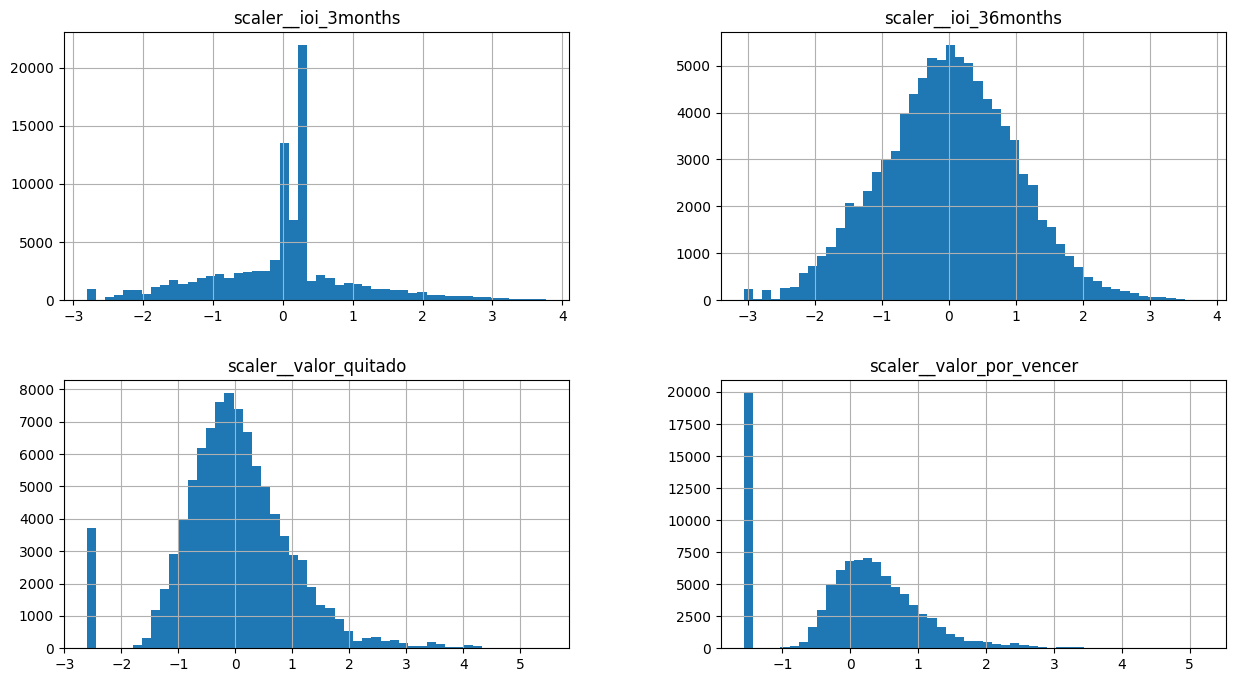

In [30]:
# box-plot
train_preparado = pd.DataFrame(
    data_set_preparado, columns = pre_processamento.get_feature_names_out(),
    dtype = np.float16,
    index = data_set.index)

train_preparado[['scaler__ioi_3months', 'scaler__ioi_36months',
                 'scaler__valor_quitado', 'scaler__valor_por_vencer']].hist(bins = 50, figsize=(15, 8))         
plt.show()  


In [31]:
# eliminar data frames nao reutilizaveis
del(train_preparado, data_set_relevant, data_set)

# <a id="dasafio4"></a> 4)  Selecionar e Treinar um Modelo

- Os modelos mais populares para reduzir a ocorrência de inadimplência de clientes são aplicados: `decision trees`, `random forest`, e `support vector machines`.

- Além disso, ajustam-se modelos de `Bayes` (mesmo com o suposto de independência potencialmente violado), `KNN` e `Logic` para explorar vantagens preditivas.


### Ajustar os modelos

In [32]:
# dados training nao redundante
X_train_relevant = relevant_variable(X_train.copy())

In [33]:
# importar funções
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [34]:
# floresta aletoria 
clf_forest = make_pipeline(pre_processamento, RandomForestClassifier(criterion = "entropy", random_state = 42))
clf_forest.fit(X_train_relevant, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('class',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function class_grouping at 0x00000297225A30D0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='i...
                                                                   KNNImputer(n_neighbors=10)),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function yeojohnson_tran at 0x00000297225A5280>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000297227D4F10>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', random_state=42))])

In [35]:
# arvore de decisao
clf_dtree = make_pipeline(pre_processamento, DecisionTreeClassifier(criterion="entropy", random_state=42))
clf_dtree.fit(X_train_relevant, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('class',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function class_grouping at 0x00000297225A30D0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='i...
                                                                   KNNImputer(n_neighbors=10)),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function yeojohnson_tran at 0x00000297225A5280>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000297227D4F10>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', random_state=42))])

In [36]:
# KNN
clf_neigh = make_pipeline(pre_processamento, KNeighborsClassifier(n_neighbors = 10))
clf_neigh.fit(X_train_relevant, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('class',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function class_grouping at 0x00000297225A30D0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='i...
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer(n_neighbors=10)),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function yeojohnson_tran at 0x00000297225A5280>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000297227D4F10>)])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10))])

In [37]:
# bayes gaussiano
clf_bayes_gauss = make_pipeline(pre_processamento, GaussianNB())
clf_bayes_gauss.fit(X_train_relevant, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('class',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function class_grouping at 0x00000297225A30D0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='i...
                                                 ('scaler',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer(n_neighbors=10)),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function yeojohnson_tran at 0x00000297225A5280>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000297227D4F10>)])),
                ('gaussiannb', GaussianNB())])

In [38]:
# regressao logistic
clf_logistic = make_pipeline(pre_processamento, LogisticRegression(max_iter = 1000, penalty = None))
clf_logistic.fit(X_train_relevant, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('class',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function class_grouping at 0x00000297225A30D0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='i...
                                                                   KNNImputer(n_neighbors=10)),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function yeojohnson_tran at 0x00000297225A5280>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000297227D4F10>)])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, penalty=None))])

### Validação Cruzada (CV)

**Lista de Modelos Promissores**

Os modelos selecionados como promissores são: `Random Forest - reguralizado`, `Decision Tree - reguralizado` e `Logistic Regression - reguralizado` e `KNN`. A escolha desses modelos é justificada da seguinte forma:

- Random Forest e Decision Tree: Sem regularização, as métricas apresentam diferenças consideráveis, indicando um melhor desempenho geral, sugerindo overfitting. No entanto, ao aplicar a regularização, observa-se uma redução no overfitting.

- Logistic Regression: se observa algumas quedas nas métricas de desempenho durante a CV. Posteriormente, se tenta aplicar a regularização Elastic Net para tentar reduzir os pesos das características menos úteis, obtenso-se estabilidade.

- KNN: As métricas de precision e F1 score indicam consistência.

- Bayes: As métricas de recall e F1 score também indicam underfitting, sugerindo a mesma consideração para modelos mais complexos, como os do primeiro grupo.



In [39]:
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score 

In [40]:
# Previsao usando CV:
y_pred_forest_cv = cross_val_predict(clf_forest, X_train_relevant, y_train, cv = 5)
y_pred_dtree_cv = cross_val_predict(clf_dtree, X_train_relevant, y_train, cv = 5)
y_pred_logic_cv = cross_val_predict(clf_logistic, X_train_relevant, y_train, cv = 5)
y_pred_knn_cv = cross_val_predict(clf_neigh, X_train_relevant, y_train, cv = 5) 
y_pred_bayes_cv = cross_val_predict(clf_bayes_gauss, X_train_relevant, y_train, cv = 5) 

# Previsao sem CV:
y_pred_forest = clf_forest.predict(X_train_relevant)
y_pred_dtree = clf_dtree.predict(X_train_relevant)
y_pred_logic = clf_logistic.predict(X_train_relevant)
y_pred_knn = clf_neigh.predict(X_train_relevant)
y_pred_bayes = clf_bayes_gauss.predict(X_train_relevant)


In [41]:
# metricas usando CV
models = [y_pred_forest_cv, y_pred_dtree_cv, y_pred_logic_cv, y_pred_knn_cv, y_pred_bayes_cv]
model_names = ["Random Forest", "Decision Tree", "KNN", "Logistic Regression", "Bayes"]

f1_scores_cv = []
precision_scores_cv = []
recall_scores_cv = []

for model, name in zip(models, model_names):
    f1_score_cv = f1_score(model, y_train).round(2)
    precision_score_cv = precision_score(model, y_train).round(2)
    recall_score_cv = recall_score(model, y_train).round(2)
    
    f1_scores_cv.append((name, f1_score_cv))
    precision_scores_cv.append((name, precision_score_cv))
    recall_scores_cv.append((name, recall_score_cv))
    
# metricas sem CV
models = [y_pred_forest, y_pred_dtree, y_pred_logic, y_pred_knn, y_pred_bayes]
model_names = ["Random Forest", "Decision Tree", "KNN", "Logistic Regression", "Bayes"]

f1_scores = []
precision_scores = []
recall_scores = []

for model, name in zip(models, model_names):
    f1_scor = f1_score(model, y_train).round(2)
    precision_scor = precision_score(model, y_train).round(2)
    recall_scor = recall_score(model, y_train).round(2)
    
    f1_scores.append((name, f1_scor))
    precision_scores.append((name, precision_scor))
    recall_scores.append((name, recall_scor))



In [42]:
# comparacao de metricas com e sem CV
print("\nF1 Scores sem CV:")
print(f1_scores)
print("F1 Scores CV:")
print(f1_scores_cv)
print("--------------------------------------------------------------------------------")
print("\nRecall Scores sem CV:")
print(recall_scores)
print("\nRecall Scores CV:")
print(recall_scores_cv)
print("--------------------------------------------------------------------------------")
print("\nPrecision Scores sem CV:")
print(precision_scores)
print("\nPrecision Scores CV:")
print(precision_scores_cv)


F1 Scores sem CV:
[('Random Forest', 1.0), ('Decision Tree', 1.0), ('KNN', 0.29), ('Logistic Regression', 0.52), ('Bayes', 0.3)]
F1 Scores CV:
[('Random Forest', 0.43), ('Decision Tree', 0.38), ('KNN', 0.29), ('Logistic Regression', 0.42), ('Bayes', 0.3)]
--------------------------------------------------------------------------------

Recall Scores sem CV:
[('Random Forest', 1.0), ('Decision Tree', 1.0), ('KNN', 0.66), ('Logistic Regression', 0.79), ('Bayes', 0.18)]

Recall Scores CV:
[('Random Forest', 0.61), ('Decision Tree', 0.35), ('KNN', 0.66), ('Logistic Regression', 0.68), ('Bayes', 0.18)]
--------------------------------------------------------------------------------

Precision Scores sem CV:
[('Random Forest', 1.0), ('Decision Tree', 1.0), ('KNN', 0.19), ('Logistic Regression', 0.39), ('Bayes', 0.96)]

Precision Scores CV:
[('Random Forest', 0.33), ('Decision Tree', 0.42), ('KNN', 0.19), ('Logistic Regression', 0.3), ('Bayes', 0.96)]


**Reguralizar os Modelos**


In [43]:
# arvore de decisao
clf_dtree2 = make_pipeline(pre_processamento, DecisionTreeClassifier(criterion="entropy", 
                                                                     min_samples_split = 200,
                                                                     random_state=42))

clf_dtree2.fit(X_train_relevant, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('class',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function class_grouping at 0x00000297225A30D0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='i...
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function yeojohnson_tran at 0x00000297225A5280>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000297227D4F10>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy',
                                        min_samples_split=200,
                                        random_state=42))])

In [44]:
# floresta aletoria 
clf_forest2 = make_pipeline(pre_processamento, RandomForestClassifier(min_samples_split = 200,
                                                                     criterion = "entropy", 
                                                                     random_state = 42))

clf_forest2.fit(X_train_relevant, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('class',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function class_grouping at 0x00000297225A30D0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='i...
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function yeojohnson_tran at 0x00000297225A5280>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000297227D4F10>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy',
                                        min_samples_split=200,
                                        random_state=42))])

In [46]:
# regressao logistic
clf_logistic2 = make_pipeline(pre_processamento, LogisticRegression(max_iter=2000, penalty='elasticnet', solver='saga', l1_ratio=0.5))
clf_logistic2.fit(X_train_relevant, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('class',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function class_grouping at 0x00000297225A30D0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='i...
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function yeojohnson_tran at 0x00000297225A5280>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000297227D4F10>)])),
                ('logisticregression',
                 LogisticRegression(l1_ratio=0.5, max_iter=2000,
                                    penalty='elasticnet', solver='saga'))])

In [47]:
# Previsao usando CV2:
y_pred_forest_cv2 = cross_val_predict(clf_forest2, X_train_relevant, y_train, cv = 5)
y_pred_dtree_cv2 = cross_val_predict(clf_dtree2, X_train_relevant, y_train, cv = 5)
y_pred_logic_cv2 = cross_val_predict(clf_logistic2, X_train_relevant, y_train, cv = 5)

In [48]:
# Previsao sem CV2:
y_pred_forest2 = clf_forest2.predict(X_train_relevant)
y_pred_dtree2 = clf_dtree2.predict(X_train_relevant)
y_pred_logic2 = clf_logistic2.predict(X_train_relevant)

In [51]:
# metricas usando CV2
models2 = [y_pred_forest_cv2, y_pred_dtree_cv2, y_pred_logic_cv2]
model_names2 = ["Random Forest", "Decision Tree", "Logistic Regression"]

f1_scores_cv2 = []
precision_scores_cv2 = []
recall_scores_cv2 = []

for model2, name2 in zip(models2, model_names2):
    f1_score_cv2 = f1_score(model2, y_train).round(2)
    precision_score_cv2 = precision_score(model2, y_train).round(2)
    recall_score_cv2 = recall_score(model2, y_train).round(2)
    
    f1_scores_cv2.append((name2, f1_score_cv2))
    precision_scores_cv2.append((name2, precision_score_cv2))
    recall_scores_cv2.append((name2, recall_score_cv2))
    
# metricas sem CV
models2 = [y_pred_forest2, y_pred_dtree2, y_pred_logic2]
model_names2 = ["Random Forest", "Decision Tree", "Logistic Regression"]

f1_scores2 = []
precision_scores2 = []
recall_scores2 = []

for model2, name2 in zip(models2, model_names2):
    f1_scor2 = f1_score(model2, y_train).round(2)
    precision_scor2 = precision_score(model2, y_train).round(2)
    recall_scor2 = recall_score(model2, y_train).round(2)
    
    f1_scores2.append((name2, f1_scor2))
    precision_scores2.append((name2, precision_scor2))
    recall_scores2.append((name2, recall_scor2))

In [52]:
# comparacao de metricas com e sem CV
print("\nF1 Scores sem CV2:")
print(f1_scores2)
print("F1 Scores CV2:")
print(f1_scores_cv2)
print("--------------------------------------------------------------------------------")
print("\nRecall Scores sem CV2:")
print(recall_scores2)
print("\nRecall Scores CV2:")
print(recall_scores_cv2)
print("--------------------------------------------------------------------------------")
print("\nPrecision Scores sem CV2:")
print(precision_scores2)
print("\nPrecision Scores CV2:")
print(precision_scores_cv2)


F1 Scores sem CV2:
[('Random Forest', 0.41), ('Decision Tree', 0.5), ('Logistic Regression', 0.29)]
F1 Scores CV2:
[('Random Forest', 0.33), ('Decision Tree', 0.35), ('Logistic Regression', 0.29)]
--------------------------------------------------------------------------------

Recall Scores sem CV2:
[('Random Forest', 0.8), ('Decision Tree', 0.71), ('Logistic Regression', 0.66)]

Recall Scores CV2:
[('Random Forest', 0.6), ('Decision Tree', 0.41), ('Logistic Regression', 0.66)]
--------------------------------------------------------------------------------

Precision Scores sem CV2:
[('Random Forest', 0.27), ('Decision Tree', 0.38), ('Logistic Regression', 0.19)]

Precision Scores CV2:
[('Random Forest', 0.23), ('Decision Tree', 0.3), ('Logistic Regression', 0.19)]


# Aperfeiçoamento do Modelo

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Definir o scoring para avaliacao de desempenho
scorer = make_scorer(f1_score)

# definir classes estimadores
def create_pipeline(estimator, **kwargs):
    return Pipeline([
        ('pre_processamento', pre_processamento),
        ('estimator', estimator(**kwargs)),
    ])

full_pipeline_forest = create_pipeline(RandomForestClassifier, criterion="entropy", random_state=42) 
full_pipeline_tree = create_pipeline(DecisionTreeClassifier, criterion="entropy", random_state=42) 
full_pipeline_knn = create_pipeline(KNeighborsClassifier, n_neighbors=10) 
full_pipeline_logistic = create_pipeline(LogisticRegression, max_iter=2000,  
                                         penalty='elasticnet', solver='saga', l1_ratio=0.5)

# grade de hiper-parametros em otimizacao
param_grid_forest_tree = [{'pre_processamento__scaler__knnimputer__n_neighbors': [5, 8, 10, 12],
                      'estimator__min_samples_split': [5, 10, 20, 50, 70, 100, 105]},
 ]

param_grid_knn = [{'pre_processamento__scaler__knnimputer__n_neighbors': [5, 8, 10, 12],
                   'estimator__n_neighbors': [5, 8, 10, 12]},
]

param_grid_logistic = [{'pre_processamento__scaler__knnimputer__n_neighbors': [5, 8, 10, 12],
                        'estimator__C': [2, 5, 10]},
]


# grade de procura de estimadores otimos
grid_search_forest = GridSearchCV(full_pipeline_forest, param_grid_forest_tree, cv = 3, scoring = scorer)
grid_search_tree = GridSearchCV(full_pipeline_tree, param_grid_forest_tree, cv = 3, scoring = scorer)
grid_search_knn = GridSearchCV(full_pipeline_knn, param_grid_knn, cv = 3, scoring = scorer)
grid_search_logistic = GridSearchCV(full_pipeline_logistic, param_grid_logistic, cv = 3, scoring = scorer)


In [72]:
# ajuste de modelos otimizados
grid_search_forest.fit(X_train_relevant, y_train)
print('---------- grid_search_forest: ok -----------')
grid_search_tree.fit(X_train_relevant, y_train)
print('---------- grid_search_tree: ok -----------')
grid_search_knn.fit(X_train_relevant, y_train)
print('---------- grid_search_knn: ok -----------')
grid_search_logistic.fit(X_train_relevant, y_train)
print('---------- grid_search_logistic: ok -----------')

---------- grid_search_forest: ok -----------
---------- grid_search_tree: ok -----------
---------- grid_search_knn: ok -----------
---------- grid_search_logistic: ok -----------


In [75]:
# Melhor combinacao de hiper-parâmetros
print(grid_search_forest.best_params_)
print(grid_search_tree.best_params_)
print(grid_search_knn.best_params_)
print(grid_search_logistic.best_params_)


{'estimator__min_samples_split': 5, 'pre_processamento__scaler__knnimputer__n_neighbors': 5}
{'estimator__min_samples_split': 5, 'pre_processamento__scaler__knnimputer__n_neighbors': 5}
{'estimator__n_neighbors': 5, 'pre_processamento__scaler__knnimputer__n_neighbors': 5}
{'estimator__C': 10, 'pre_processamento__scaler__knnimputer__n_neighbors': 5}


# <a id="desafio5"></a> 5) Análise e seleção dos melhores modelos

**Curva PR (Presição/Recall) e Curva ROC (Recall vs TFP)**
- Neste caso, busca-se reduzir os falsos negativos (aumentar *recall*) em meio a uma maioria de dados negativos. Opta-se pela *curva PR* devido à sensibilidade ao desequilíbrio de classes. Entretanto, construímos ambas as curvas PR e ROC para análise completa.
- Como demonstrado a seguir:
    - Tanto a *curva PR* quanto a *curva ROC* indicam que há espaço significativo para melhorias nos classificadores. Considerar modelos de redes neurais pode resultar em melhorias adicionais.
    - No entanto, entre os modelos promissores avaliados, se observa que o classificador de árvore de decisão teve o desempenho menos desfavorável em termos de previsão, com uma AUC na curva ROC de `0.449`.

## Curva PR

In [136]:
# Funcoes scores e probabilidade de previsao dos modelos
y_scores_forest = grid_search_forest.predict_proba(X_train_relevant)
y_scores_tree = grid_search_tree.predict_proba(X_train_relevant)
y_scores_logic = grid_search_logistic.predict_proba(X_train_relevant)
y_scores_neigh = grid_search_knn.predict_proba(X_train_relevant)

# Curva PR usando CV
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train, y_scores_forest.max(axis = 1))
precisions_tree, recalls_tree, thresholds_tree = precision_recall_curve(y_train, y_scores_tree.max(axis = 1))
precisions_logic, recalls_logic, thresholds_logic = precision_recall_curve(y_train, y_scores_logic.max(axis = 1))
precisions_neigh, recalls_neigh, thresholds_neigh = precision_recall_curve(y_train, y_scores_neigh.max(axis = 1))

# limear de recall de 90% 
idx_for_90_recalls_forest = (recalls_forest >= 0.90).argmax()
threshold_for_90_recalls_logic = thresholds_forest[idx_for_90_recalls_logic]

idx_for_90_recalls_tree = (recalls_tree >= 0.90).argmax()
threshold_for_90_recalls_tree = thresholds_tree[idx_for_90_recalls_tree]

idx_for_90_recalls_logic = (recalls_logic >= 0.90).argmax()
threshold_for_90_recalls_logic = thresholds_logic[idx_for_90_recalls_logic]

idx_for_90_recalls_neigh = (recalls_neigh >= 0.90).argmax()
threshold_for_90_recalls_neigh = thresholds_neigh[idx_for_90_recalls_neigh]

idx_for_90_recalls_neigh = (recalls_neigh >= 0.90).argmax()
threshold_for_90_recalls_neigh = thresholds_neigh[idx_for_90_recalls_neigh]

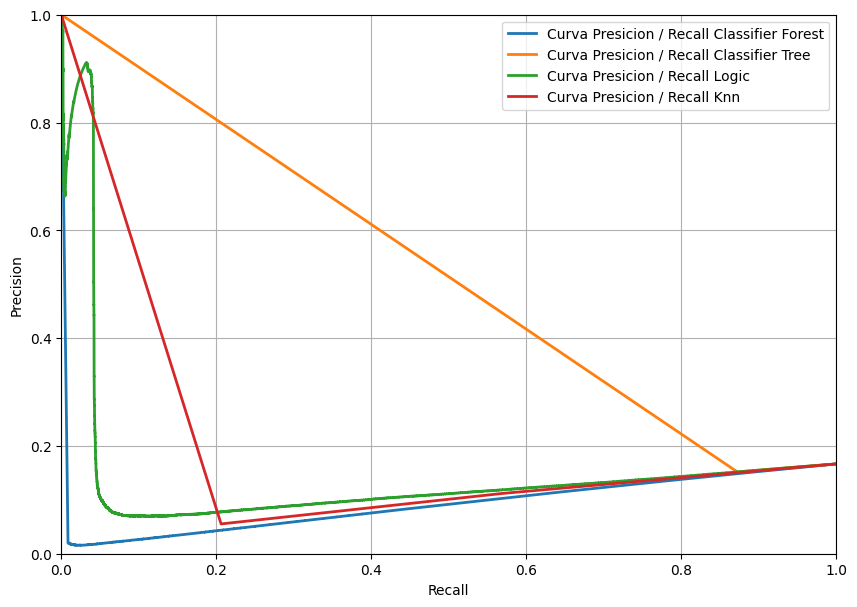

In [142]:
# curva PR
import matplotlib.patches as patches 

plt.figure(figsize = (10, 7))  

plt.plot(recalls_forest, precisions_forest, linewidth = 2, label = "Curva Presicion / Recall Classifier Forest")
plt.plot(recalls_tree, precisions_tree, linewidth = 2, label = "Curva Presicion / Recall Classifier Tree")
plt.plot(recalls_logic, precisions_logic, linewidth = 2, label = "Curva Presicion / Recall Logic")
plt.plot(recalls_neigh, precisions_neigh, linewidth = 2, label = "Curva Presicion / Recall Knn")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc=1)
# save_fig("precision_vs_recall_plot")
plt.show()

## Curva ROC

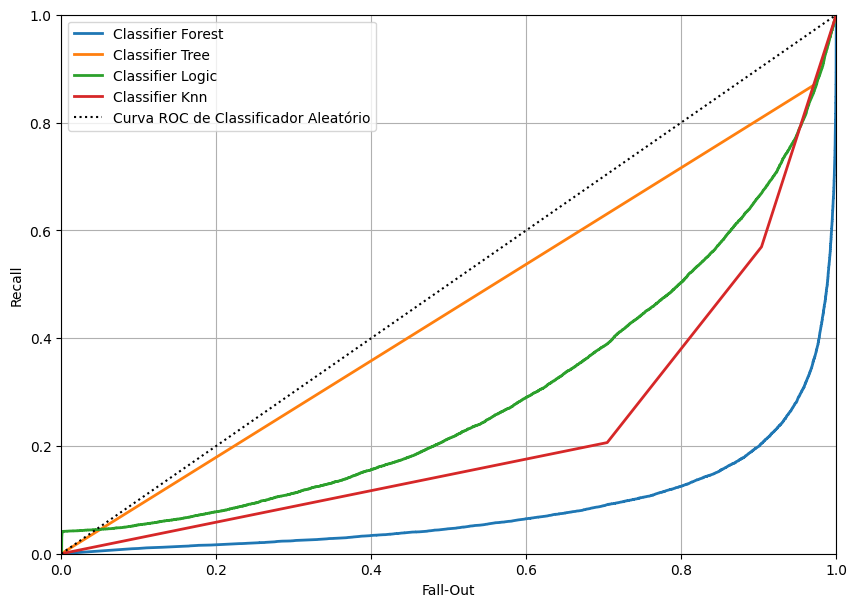

In [156]:
# Curva ROC
from sklearn.metrics import roc_curve

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest.max(axis = 1))
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_train, y_scores_tree.max(axis = 1))
fpr_logic, tpr_logic, thresholds_logic = roc_curve(y_train, y_scores_logic.max(axis = 1))
fpr_neigh, tpr_neigh, thresholds_logic = roc_curve(y_train, y_scores_neigh.max(axis = 1))

# plot
plt.figure(figsize=(10, 7)) 

plt.plot(fpr_forest, tpr_forest, linewidth=2, label = "Classifier Forest ")
plt.plot(fpr_tree, tpr_tree, linewidth=2, label = "Classifier Tree ")
plt.plot(fpr_logic, tpr_logic, linewidth=2, label = "Classifier Logic")
plt.plot(fpr_neigh, tpr_neigh, linewidth=2, label = "Classifier Knn")

plt.plot([0, 1], [0, 1], 'k:', label="Curva ROC de Classificador Aleatório")

plt.xlabel('Fall-Out')
plt.ylabel('Recall')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc= 0)

plt.show()

In [162]:
# area baixo a curva ROC
from sklearn.metrics import roc_auc_score
print("AUC do modelo Classifier Forest:", roc_auc_score(y_train, y_scores_forest.max(axis = 1)).round(3))
print("AUC do modelo Classifier Tree:", roc_auc_score(y_train, y_scores_tree.max(axis = 1)).round(3))
print("AUC do modelo Logic:", roc_auc_score(y_train, y_scores_logic.max(axis = 1)).round(3))
print("AUC do modelo KNN:", roc_auc_score(y_train, y_scores_neigh.max(axis = 1)).round(3))

AUC do modelo Classifier Forest: 0.083
AUC do modelo Classifier Tree: 0.449
AUC do modelo Logic: 0.293
AUC do modelo KNN: 0.226



# <a id="desafio6"></a> 6) Modelo final e avaliação o sitema no conjunto de teste

##### Modelo Final:

In [183]:
# modelo ajusta
modelo_final = grid_search_tree

#### Avaliação final

In [191]:
final_hat = modelo_final.predict(X_test)
f1_score_final = f1_score(final_hat, y_test).round(2)
precision_score_final = precision_score(final_hat, y_test).round(2)
recall_score_final = recall_score(final_hat, y_test).round(2)

In [192]:
result = {'F1_score': f1_score_final, 'Presicion_score': precision_score_final, 'recall': recall_score_final}
print(result)

{'F1_score': 0.4, 'Presicion_score': 0.41, 'recall': 0.39}


#### salvar modelo final


In [194]:
# Salvar modelos otimizados (opcional)
 joblib.dump(modelo_final, "my_model_final.pkl")

IndentationError: unexpected indent (2200705364.py, line 2)

## Muito obrigado por estar comigo